# **`Objective`**

Forecast short-term household energy usage using historical time-based patterns and compare multiple forecasting models (ARIMA, Prophet, XGBoost).

# **Step 1 – Import Libraries**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# **Step 2 – Load and Parse Dataset**

In [4]:
# Load dataset
df = pd.read_csv('household_power_consumption.txt', sep=';',
                 parse_dates={'Datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])

# Convert to numeric
df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')

# Drop missing values
df.dropna(subset=['Global_active_power'], inplace=True)

# Set Datetime as index and convert to DatetimeIndex
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

# **Step 3 – Resample Data**

Aggregate by hour (or day) for smoother time series.

In [5]:
df_resampled = df['Global_active_power'].resample('H').mean()

# **Step 4 – Feature Engineering**

Create time-based features.

In [6]:
data = df_resampled.reset_index()
data['hour'] = data['Datetime'].dt.hour
data['dayofweek'] = data['Datetime'].dt.dayofweek
data['is_weekend'] = (data['dayofweek'] >= 5).astype(int)

# **Step 5 – Train-Test Split**

In [9]:
split_date = '2008-05-01'
train = data[data['Datetime'] < split_date]
test = data[data['Datetime'] >= split_date]

# **Step 6 – Model 1: ARIMA**

In [10]:

from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(train['Global_active_power'], order=(5,1,0))
fit_arima = model_arima.fit()
pred_arima = fit_arima.forecast(steps=len(test))

# **Step 7 – Model 2: Prophet**

In [11]:

from prophet import Prophet

prophet_df = train[['Datetime', 'Global_active_power']].rename(columns={'Datetime': 'ds', 'Global_active_power': 'y'})
model_prophet = Prophet()
model_prophet.fit(prophet_df)

future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp435ch_5q/pft0_ylw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp435ch_5q/xvowqsra.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19644', 'data', 'file=/tmp/tmp435ch_5q/pft0_ylw.json', 'init=/tmp/tmp435ch_5q/xvowqsra.json', 'output', 'file=/tmp/tmp435ch_5q/prophet_modelgwgcg464/prophet_model-20251006165340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:53:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:53:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# **Step 8 – Model 3: XGBoost**

In [13]:
from xgboost import XGBRegressor

X_train = train[['hour', 'dayofweek', 'is_weekend']]
y_train = train['Global_active_power']
X_test = test[['hour', 'dayofweek', 'is_weekend']]
y_test = test['Global_active_power']

# Check for and handle invalid values in y_train
y_train = y_train[np.isfinite(y_train)]
X_train = X_train.loc[y_train.index]


model_xgb = XGBRegressor(objective='reg:squarederror', n_estimators=100)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict(X_test)

# **Step 9 – Evaluation Metrics**

In [14]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

mae_arima, rmse_arima = evaluate(test['Global_active_power'], pred_arima)
mae_prophet, rmse_prophet = evaluate(test['Global_active_power'], forecast_prophet['yhat'][-len(test):])
mae_xgb, rmse_xgb = evaluate(y_test, pred_xgb)

results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
})
print(results)

     Model       MAE      RMSE
0    ARIMA  0.706745  1.054898
1  Prophet  0.559932  0.761768
2  XGBoost  0.562992  0.754348


# **Step 10 – Visualization**

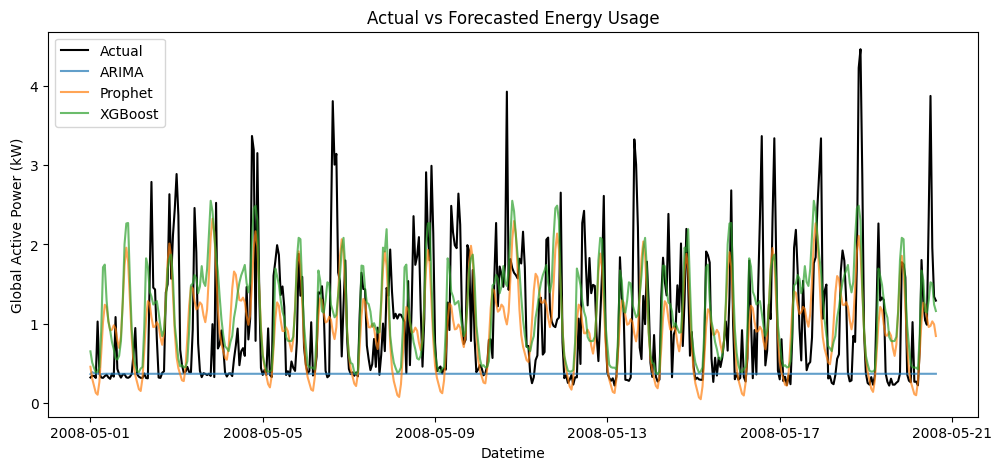

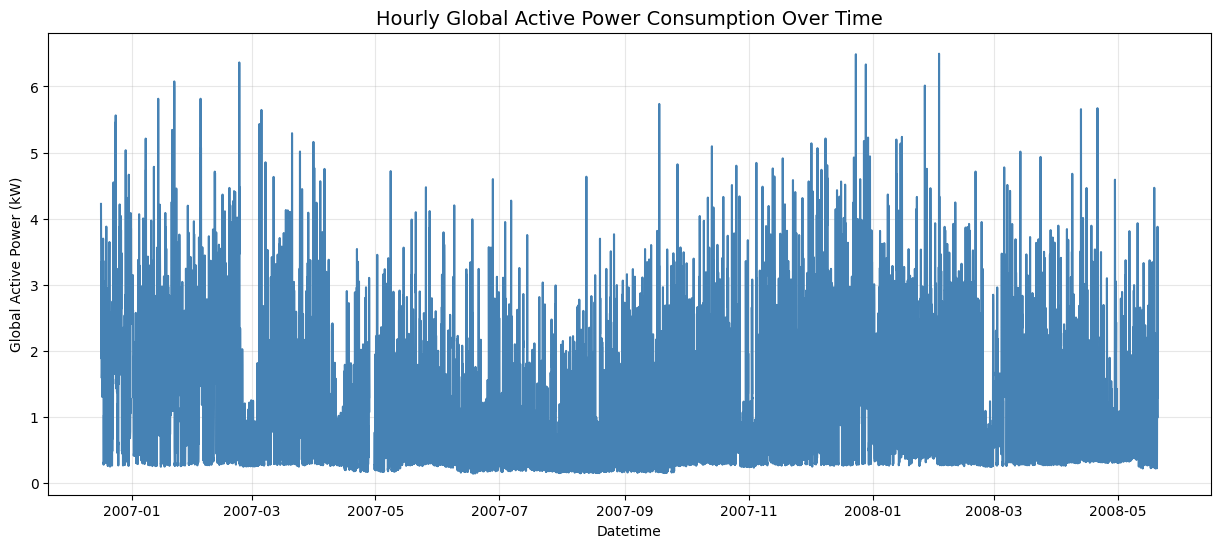

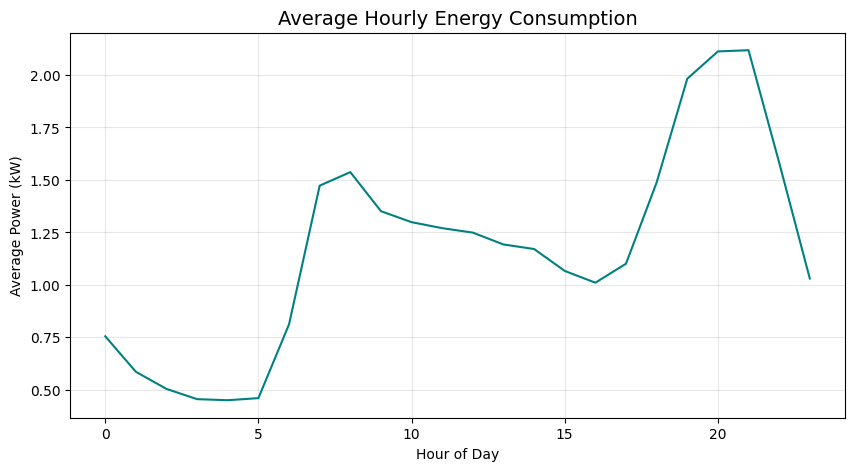

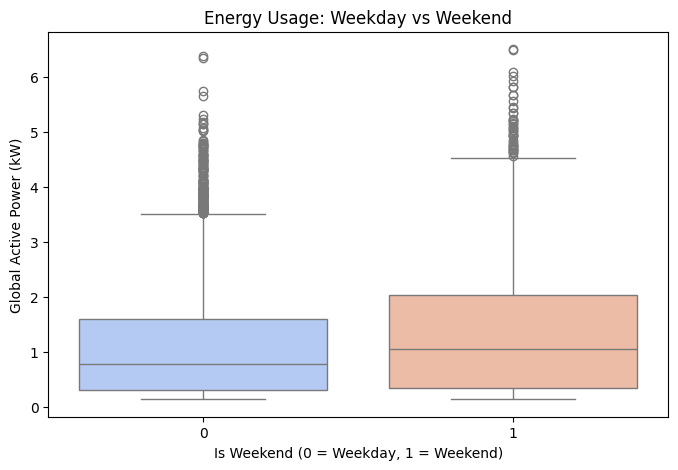

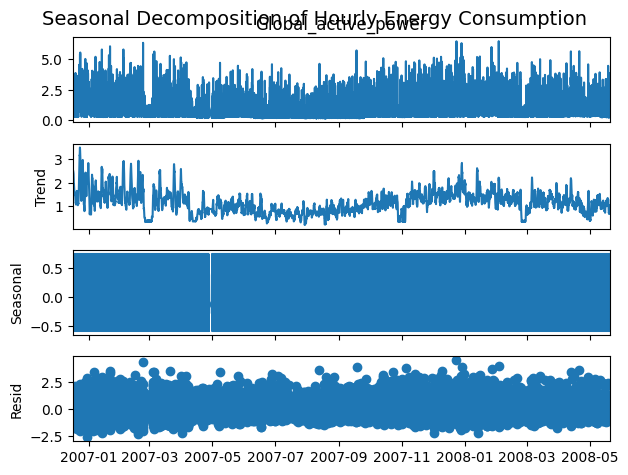

In [17]:

plt.figure(figsize=(12,5))
plt.plot(test['Datetime'], test['Global_active_power'], label='Actual', color='black')
plt.plot(test['Datetime'], pred_arima, label='ARIMA', alpha=0.7)
plt.plot(test['Datetime'], forecast_prophet['yhat'][-len(test):].values, label='Prophet', alpha=0.7)
plt.plot(test['Datetime'], pred_xgb, label='XGBoost', alpha=0.7)
plt.title('Actual vs Forecasted Energy Usage')
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

plt.figure(figsize=(15,6))
plt.plot(df_resampled, color='steelblue')
plt.title('Hourly Global Active Power Consumption Over Time', fontsize=14)
plt.xlabel('Datetime')
plt.ylabel('Global Active Power (kW)')
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=data, x='hour', y='Global_active_power', ci=None, color='teal')
plt.title('Average Hourly Energy Consumption', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x='is_weekend', y='Global_active_power', data=data, palette='coolwarm')
plt.title('Energy Usage: Weekday vs Weekend')
plt.xlabel('Is Weekend (0 = Weekday, 1 = Weekend)')
plt.ylabel('Global Active Power (kW)')
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_resampled.dropna(), model='additive', period=24)
result.plot()
plt.suptitle('Seasonal Decomposition of Hourly Energy Consumption', fontsize=14)
plt.show()

